# skorch를 활용하여 torch + scikit-learn pipeline 결합해보기

In [1]:
# preprocessors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
# 시각화용 config 

# font properties
plt.rcParams["mathtext.fontset"] = "cm"
font_label = {"color":"gray"}
font_title = {"color":"k"}
font_metrics = {'color':'k', 'fontsize':"medium"}

# colors
c_train = "green"
c_val = "orange"
c_test = "magenta"

In [3]:
# 데이터는 비교하기 쉽게 다시 펭귄 
import seaborn as sns 

# seaborn sampe 데이터 
df_peng = sns.load_dataset("penguins")  # 펭귄 데이터셋
df_peng = df_peng.dropna()              # 결측치 제거

df_peng.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [4]:
# X:y로 데이터 분할

# 몸무게만 y
y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1) # 몸무게가 있는 컬럼만 날리고 나머지 모두 axis=1의 의미 

print(f'X의 shape: {X.shape} | y의 shap: {y.shape}')

X의 shape: (333, 6) | y의 shap: (333,)


In [119]:
from sklearn.model_selection import train_test_split
rng = np.random.RandomState(0) # random seed : 여기서 필요한지는 모르겠음 

# stratify를 쓰는 이유: split한 데이터 집합 간의 불균형 해결 (e.g. X_train에만 유난히 남성 비율이 높다) 
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, 
                                                    stratify=X[["species", "island", "sex"]])
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.25, random_state=rng, 
                                                    stratify=X_Train[["species", "island", "sex"]])

print(f'X_train: {X_train.shape} | y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} | y_test: {y_test.shape}')
print(f'X_val: {X_val.shape} | y_val: {y_val.shape}')

X_train: (39, 6) | y_train: (39,)
X_test: (14, 6) | y_test: (14,)
X_val: (14, 6) | y_val: (14,)


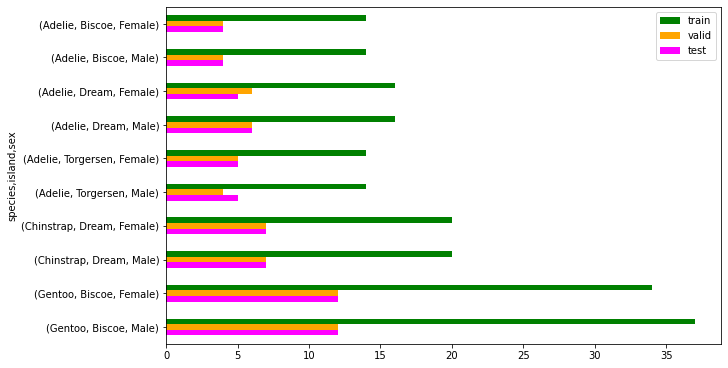

In [6]:
# 카테고리 요소 Visualization

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

cols_cat = ["species", "island", "sex"]
df_tmp = 0
for i, (X, col) in enumerate(zip([X_train, X_val, X_test], ["train", "valid", "test"])):
    if isinstance(df_tmp, int):
        df_tmp = pd.DataFrame(X[cols_cat].value_counts(), columns=[col]).sort_index()
    else:
        df_tmp = pd.concat([df_tmp, pd.DataFrame(X[cols_cat].value_counts(), columns=[col]).sort_index()], axis=1)

df_tmp.plot.barh(ax=ax, color={"train":c_train, "valid":c_val, "test":c_test}).invert_yaxis()

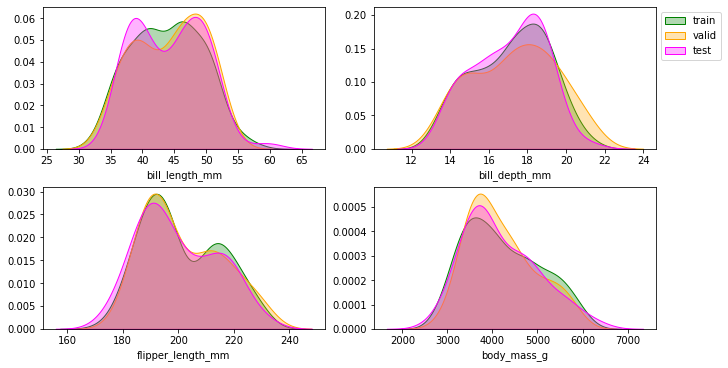

In [7]:
# 숫자 값 Visualization

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 5), constrained_layout=True)

cols_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]

# numerical X features
for ax, col in zip(axes.ravel(), cols_num):
    for X, c in zip([X_train, X_val, X_test], [c_train, c_val, c_test]):
        sns.kdeplot(x=col, data=X, ax=ax, fill=True, alpha=0.3, color=c)
        ax.set_ylabel("")

# y feature
for y, c in zip([y_train, y_val, y_test], [c_train, c_val, c_test]):
    sns.kdeplot(data=y, ax=axes[1, 1], fill=True, alpha=0.3, color=c)
    axes[1, 1].set_ylabel("")

axes[0, 1].legend(handles=axes[1, 1].collections, labels=["train", "valid", "test"],
                  loc="upper left", bbox_to_anchor=(1, 1))

In [8]:
# 필요한 Functions

# 두 개 합치기 
# Preprocessings for Categorical and Numerical features
def get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    # categorical features: one-hot encoding
    cat_features = cols_cat
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # numerical features: standard scaling & polynomial features
    num_features = cols_num
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)),
                                      ("scaler", StandardScaler())])
    
    numcat = ColumnTransformer(transformers=[("categorical", cat_transformer, cat_features),
                                          ("numerical", num_transformer, num_features)])
    return numcat

# Float64 to Float32 for PyTorch 
# 사이킷런과 파이토치는 기본적으로 처리 데이터 크기가 다름 
class FloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array(X, dtype=np.float32)


# preprocessing Pipeline
def get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    concat = get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    ft = FloatTransformer()

    pipeline= Pipeline(steps=[("concat", concat), 
                              ("float64to32", ft)])
    return pipeline

In [199]:
import torch
from torch import nn
from torch import optim

# neural network: ninput(12)-16-16-12-8-1
class Net(nn.Module):
    def __init__(self, ninput=12):
        super().__init__()
        self.layer0 = nn.Linear(ninput, 16)
        self.layer1 = nn.Linear(16, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        #self.activation1 = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.layer0(x))
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

# loss: RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
    def forward(self, true, pred):
        loss = torch.sqrt(self.mse(true, pred) + self.eps)
        return loss

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# GPU is not available


In [115]:
# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# embedding pytorch model in scikit-learn Pipeline
from skorch import NeuralNetRegressor

# callbacks
from skorch.callbacks import Callback
from skorch.callbacks import LRScheduler
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

# Learning Rate Scheduler
from torch.optim.lr_scheduler import OneCycleLR, LinearLR

# dynamic input size of the PyTorch module
class InputShapeSetter(Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__ninput=X.shape[1])

epochs = 1000 # number of max. epochs
check_point_dir = 'checkpoint'

# save the model parameters, optimizer, and history
cp = Checkpoint(dirname=check_point_dir)
train_end_cp = TrainEndCheckpoint(dirname=check_point_dir)

# skorch ML pipeline
def get_model(method='lr', device=device, cols_cat=cols_cat, cols_num=cols_num, degree=1, 
              callbacks=[('input_shape_setter', InputShapeSetter()),
                         ('lr_scheduler', LRScheduler(policy=OneCycleLR, max_lr=0.1, total_steps=epochs)),
                         ('early_stopping', EarlyStopping(monitor='valid_loss', patience=20)),
                         ('checkpoint', cp), ('train_end_checkpoint', train_end_cp)], 
              **kwargs):
    
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor(random_state=rng)
    elif method == "nn":
        ml = NeuralNetRegressor(Net(), device=device, callbacks=callbacks, **kwargs)
    else:
        print("# 'method' should be in ['lr', 'rf', 'nn'].")
        return None
    
    preprocessor = get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    model = Pipeline([("preprocessor", preprocessor), 
                      ("ml", ml)])
    
    return model

In [159]:
# 시각화 functions 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def plot_parity(true, pred, kind="scatter", 
                xlabel="true", ylabel="predict", title="", 
                hist2d_kws=None, scatter_kws=None, kde_kws=None,
                equal=True, metrics=True, metrics_position="lower right",
                figsize=(5, 5), ax=None, filename=None):
    
    fig = None
    if not ax:
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # data range
    val_min = min(true.min(), pred.min())
    val_max = max(true.max(), pred.max())
    data_range = val_max - val_min

    # data plot
    if "scatter" in kind:
        if not scatter_kws:
            scatter_kws={'color':'green', 'alpha':0.5}
        ax.scatter(true, pred, **scatter_kws)
    elif "hist2d" in kind:
        if not hist2d_kws:
            hist2d_kws={'cmap':'Greens', 'vmin':1, 'bins':30}
        ax.hist2d(true, pred, **hist2d_kws)
    elif "kde" in kind:
        if not kde_kws:
            kde_kws={'cmap':'viridis', 'levels':5}
        sns.kdeplot(x=true, y=pred, **kde_kws, ax=ax)

    # x, y bounds
    bounds = (val_min - data_range*0.1, val_max + data_range*0.1)
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)

    # x, y ticks, ticklabels
    ticks = [int(y) for y in ax.get_yticks() if ((100*y)%100 == 0) and (val_min <= y <= val_max)]
    ax.set_xticks(ticks, ticks)
    ax.set_yticks(ticks, ticks)

    # grid
    ax.grid(True)

    # 기준선
    ax.plot(bounds, bounds, c="k", alpha=0.3)

    # x, y label
    font_label = {"color":"gray"}
    ax.set_xlabel(xlabel, fontdict=font_label, labelpad=12)
    ax.set_ylabel(ylabel, fontdict=font_label, labelpad=12)

    # title
    font_title = {"color": "gray", "fontweight":"bold"}
    ax.set_title(title, fontdict=font_title, pad=16)

    # metrics
    if metrics:
        rmse = mean_squared_error(true, pred, squared=False)
        mae = mean_absolute_error(true, pred)
        r2 = r2_score(true, pred)

        if metrics_position == "lower right":
            text_pos_x = 0.98
            text_pos_y = 0.3
            ha = "right"
        elif metrics_position == "upper left":
            text_pos_x = 0.1
            text_pos_y = 0.9
            ha = "left"
        else:
            text_pos_x, text_pos_y = metrics_position
            ha = "left"

        ax.text(text_pos_x, text_pos_y, f"RMSE = {rmse:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)
        ax.text(text_pos_x, text_pos_y-0.1, f"MAE = {mae:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)
        ax.text(text_pos_x, text_pos_y-0.2, f"R2 = {r2:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)

    # 파일로 저장
    if fig and filename:
            fig.savefig(filename)

    return ax

def plot_epoch(history=None, loss_trains=None, loss_vals=None, ax=None):
    
    if any([history, loss_trains]) == False:
        print("# one of 'history' and 'loss_trains' has to be used!")
        return ax
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if loss_trains == None:
        loss_trains = history[:, "train_loss"]

    if history != None and loss_vals == None:
        loss_vals = history[:, "valid_loss"]

    ax.plot(list(range(1, len(loss_trains)+1)), loss_trains, c=c_train, label="train")
    if loss_vals != None:
        ax.plot(list(range(1, len(loss_vals)+1)), loss_vals, c=c_val, label="valid")
    ax.grid(axis="y")
    ax.set_xlabel("epochs", fontdict=font_label)
    ax.legend()

    return ax

def plot_parity3(model, target=["train", "val", "test"], figsize=(10, 4),
                 Xs=None, trues=None, preds=None, colors=None):
    if not Xs:
        Xs = [eval(f"X_{t}") for t in target]
    if not trues:
        trues = [eval(f"y_{t}") for t in target]
    if not preds:
        preds = [model.predict(X) for X in Xs]
    if not colors:
        colors = [eval(f"c_{t}") for t in target]

    fig, axs = plt.subplots(ncols=len(target), figsize=figsize, constrained_layout=True)
    for ax, true, pred, c, title in zip(axs, trues, preds, colors, ["train", "validation", "test"]):
        plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
        if ax != axs[0]:
            ax.set_ylabel("")

In [200]:
from skorch.dataset import Dataset
from skorch.helper import predefined_split

# ys (numpy)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32)
y_val_np = y_val.values.reshape(-1, 1).astype(np.float32)
y_test_np = y_test.values.reshape(-1, 1).astype(np.float32)

# predefined validation set
preprocessor = get_preprocessor()
X_val_pp = preprocessor.fit(X_train).transform(X_val)
valid_dataset = Dataset(X_val_pp, y_val_np)

# model training
epochs= 1000
LR = 1e-3
model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = LR,
                  train_split=predefined_split(valid_dataset))   # predefined validataion set
model.fit(X_train, y_train_np)

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1     4290.0615     4134.3608     +  0.0040  0.0054
      2     4290.0342     4134.3330     +  0.0040  0.0049
      3     4290.0073     4134.3057     +  0.0040  0.0044
      4     4289.9805     4134.2778     +  0.0040  0.0083
      5     4289.9531     4134.2520     +  0.0040  0.0049
      6     4289.9268     4134.2266     +  0.0041  0.0069
      7     4289.9019     4134.2017     +  0.0041  0.0067
      8     4289.8765     4134.1753     +  0.0041  0.0051
      9     4289.8501     4134.1470     +  0.0042  0.0045
     10     4289.8208     4134.1172     +  0.0042  0.0052
     11     4289.7900     4134.0859     +  0.0043  0.0059
     12     4289.7583     4134.0532     +  0.0043  0.0066
     13     4289.7271     4134.0186     +  0.0044

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=16, bias=True)
    (layer3): Linear(in_features=16, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

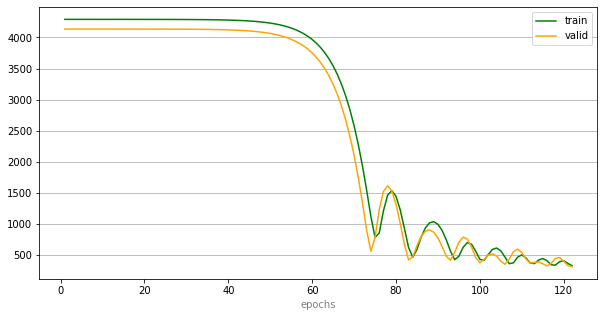

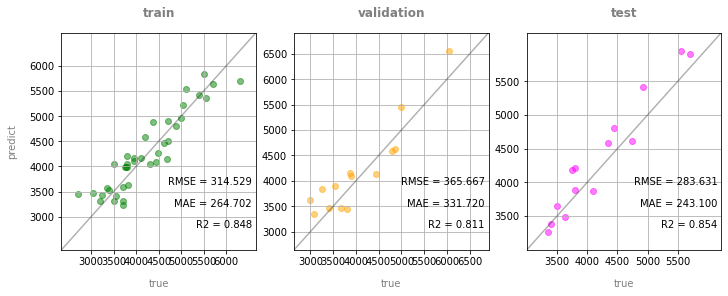

In [201]:
from skorch.history import History

# learning curve
history = History().from_file(f'./{check_point_dir}/history.json')
ax = plot_epoch(history)

plot_parity3(model)


In [162]:
linearR = get_model(method='lr', train_split=predefined_split(valid_dataset))
linearR.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('float64to32', FloatTransformer())])),
                ('ml', LinearRegression())])

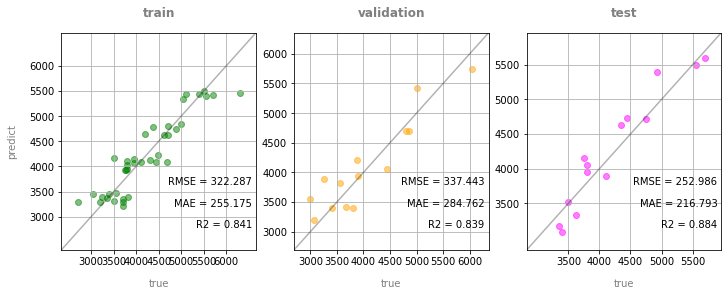

In [163]:
plot_parity3(linearR)


In [164]:
rfr = get_model(method='rf', train_split=predefined_split(valid_dataset))
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('float64to32', FloatTransformer())])),
                ('ml',
                 RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F8D4BABC940))])

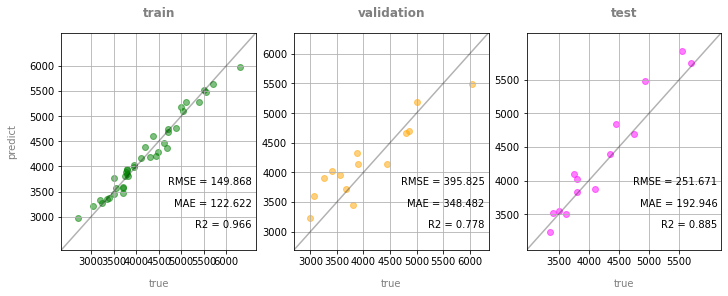

In [165]:
plot_parity3(rfr)